##### Note: 

This notebook contains work completed prior to the development of this codebase and thus does not utilize any backtesting functionality

##### Introduction 

Throughout this notebook a machine learning algorithm will be developed for a trading model. The particular class of machine learning method applied in this project is supervised learning where labelled data is need to train algorithms. The labels will be calculated using outcomes from possible trades. For the following trading model only historical price data will be used. The particular data used in this report is from IG Group, a financial services company that provides spread betting for derivative markets. 
 
This notebook proceeds to develop and implement a basic machine learning pipeline in context of day trading. The outline for the remaining sections are -
1. Define a trading strategy. 
2. Calculate outcomes for data instances using the exit strategy from 1.  
3. Train a model for trading task.  
4. Tune hyperparameters 
5. Evaluate results 

The remaining section briefly introduces some key trading statistics used throughout and the key model architecture relevant in the modelling section.

Expectancy is a key metric used for defining profitable trading models from unprofitable trading models. Expectancy is simply just the expectation of profits. 

$$ \mathbb{E}[O] = \sum{prob(\text{outcome})*\text{outcome}} = prob_{\text{win}} * \text{win} - prob_{\text{loss}} * \text{loss}$$

Expectancy can be considered the profit from a single trade on average. If Expectancy is below 0 the trading model is not profitable. If Expectancy is equal to 0 the trading model will breakeven. Finally, if the Expectancy is greater than 0 the trading model is profitable. Note profitable trading with such models assumes the performance of such models continues on new unseen data. 

A useful form of Expectancy is obtained by rescaling by loss and introducing new terms accuracy and win-loss ratio.

$$ \text{Expectancy ratio} = \frac{\mathbb{E}[O]}{\text{loss}} = prob_{\text{win}} * \text{win}/\text{loss} - prob_{\text{loss}} = \text{accuracy} * \text{win}/\text{loss} - 1 + \text{accuracy}$$

Setting the Expectancy ratio to greater than zero provides a bound defining profitable from unprofitable models in terms of accuracy of trades and win/loss ratio. The following equation, eq1, is found for profitable models - 

$$ \text{accuracy}(1 + \text{win}/\text{loss}) > 1 $$

For completion, to calculate profit of a model on some data you multiple expectancy by the number of trading opportunities, eq2 - 

$$ \text{profit} = \mathbb{E}[O] * \text{number of trades} $$

For this notebook the model architecture will be a neural network, specifically containing Long Short Term Memory (LSTM) units. LSTMS allow bi-directional flow of information and contain internal states, long and short term memory. The ability to process arbitrary sequences of inputs and store temporal behaviour makes them applicable to forecasting trading outcomes from timeseries data. For further detail on LTSM architecture see [1]. 

[1] Yong Yu, Xiaosheng Si, Changhua Hu, Jianxun Zhang; A Review of Recurrent Neural Networks: LSTM Cells and Network Architectures. Neural Comput 2019; 31 (7): 1235–1270.

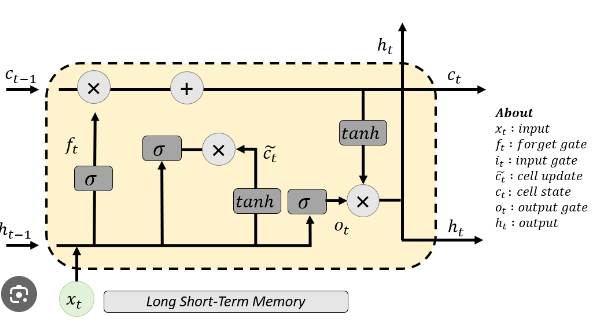

#### Strategy

Trading is a particular task where sequential decisions have to be made. In general strategies are required to realize consistent profit from trading. There are multiple actions that can be utilised in building strategies such as buy, hold sell, stop_loss, tailing_loss, etc. It is important to note there are however constraints to certain actions depending on the broker, account limits and current state of the environment. In essence a strategy are defined to specify when to enter and exit trades. The strategy that will be used in this notebook is not extensive but will help facilitate highlighting some of the key components of developing mechanical trading models. The strategy used is now defined -

>Entry: Model predicts to open a long position using the current n previous 1min opens. The model is also constrained to only open positions on 1min opens. 
>
>Exit: Open positions will be closed once a 1min bar opens above or below the entry price by m points. (Note broker spreads will need to be included when implemented).

The following strategy is relatively simple. The entry strategy has little proprietary modelling where only a single timeframe is used being evaluated on only 1min opens. Furthermore there are no constraints on previous market behaviour. The strategies exit method is also relatively simple using a discretise 1:1 profit stop-loss. The exit strategy though simple in the context of trading could be potentially profitable if appropriate trading accuracies can be performed. Though more complex trading models can be developed there is still some complexity in the model inheritance in the neural network architecture. Furthermore the model does contain a number of parameter, the length of the input sequence and m the price levels for the exit strategy. A schematic of a trading instance is shown below.

<div style="text-align:center;">
    <img src="trading_instances.png" width="500" height="500" />
    <p style="margin-top: 10px;">Schemtic of trading instace for a long trade with outcome win. The input sequence (blue line) is n=3. The exit is a 1:1 win/loss with m=10 for the price levels.</p>
</div>


Before proceeding to preprocesses the data and construct a machine learning model the trading accuracy needed for the strategy to be profitable is calculated. Using eq(1) and the win/loss ratio defined in the strategy accuracy can be calculated. Note for this particular strategy the win/loss ratio for the strategy is not deterministic as the exit levels of open positions depend on 1min opens. The win/loss ratio is calculated from the mean wins and mean losses and thus will depend on the trading data. For the proceeding calculation its assumed on average the ratio remains 1:1 and the threshold trading accuracy is calculated.

$$ \text{accuracy}(1 + \text{win}/\text{loss}) > 1 $$
$$ \text{accuracy} > 1/2 $$

For a 1:1 risk to reward you need a trading accuracy greater than 0.5. In other words you need more winning trades than losing trades. Using eq(2) with a target of 50 points a week and assumed accuracy of 0.6 the number of opportunities needed is calculated - 

$$ \text{profit} = \mathbb{E}[O] * \text{number of trades} $$

$$ \mathbb{E}[O] == \text{accuracy} * \text{win} - (1-\text{accuracy}) * \text{loss} = 0.6*10 - 0.4*10 = 2 \text{ points per trade}$$

$$ \text{number of trades per week} = 50/2 = 25 \text{ trades per week}$$  

For the above strategy you can profit on average 50 points a week if you trade 25 opportunities with an accuracy of 0.6.

#### Data preprocessing

##### Inport raw data obtaind from IG markets 

The specific data used here is from IG's indice market Germany 40 for 1min data. 

In [20]:
import os
import pandas as pd
import numpy as np

folder_path = 'data/DAX/1min'

file_list = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
data = pd.DataFrame()
for file in file_list:
    file_path = os.path.join(folder_path, file)
    
    df = pd.read_csv(file_path)
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    
    data = pd.concat([data, df], ignore_index=True)

In [21]:
data

,DateTime,Open,High,Low,Close
0,2023-11-06 07:31:00,15196.5,15200.0,15196.5,15198.5
1,2023-11-06 07:32:00,15199.0,15202.5,15198.0,15201.0
2,2023-11-06 07:33:00,15200.5,15203.5,15199.5,15203.5
3,2023-11-06 07:34:00,15204.0,15205.5,15203.5,15203.5
4,2023-11-06 07:35:00,15204.0,15205.0,15203.0,15204.5
...,...,...,...,...,...
1427,2023-12-06 10:25:00,16555.0,16556.5,16554.5,16555.5
1428,2023-12-06 10:26:00,16556.0,16556.5,16554.5,16555.5
1429,2023-12-06 10:27:00,16556.0,16558.5,16555.5,16556.5
1430,2023-12-06 10:28:00,16557.0,16557.5,16555.5,16557.5


##### Label data using exit strategy

Outcomes of the trades can be calculated using the entry and exit strategy defined. 

In [22]:
def index_range(current_index, trades):

    given_date = trades.loc[current_index, 'DateTime'].date()
    matching_indices = trades[trades['DateTime'].dt.date.eq(given_date)].index

    final_index = matching_indices[-1]

    return range(current_index, final_index)

In [23]:
data['DateTime'] = pd.to_datetime(data['DateTime'])

data = data[['DateTime', 'Open']]

for index in data.index:

    entry = data.loc[index, 'Open']

    target = 5
    stop_loss = 5
    spread = 1.4
    price_loss = entry - stop_loss + spread
    price_win = entry + target + spread

    for sec_index in index_range(index, data):
        if data.loc[sec_index, 'Open'] <= price_loss:
            data.loc[index, 'Outcome'] = 0
            break  
        elif data.loc[sec_index, 'Open'] >= price_win:
            data.loc[index, 'Outcome'] = 1
            break


C:\Users\richa\AppData\Local\Temp\ipykernel_25852\369778591.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[index, 'Outcome'] = 1


In [24]:
data.head(10)

,DateTime,Open,Outcome
0,2023-11-06 07:31:00,15196.5,1.0
1,2023-11-06 07:32:00,15199.0,1.0
2,2023-11-06 07:33:00,15200.5,1.0
3,2023-11-06 07:34:00,15204.0,1.0
4,2023-11-06 07:35:00,15204.0,1.0
5,2023-11-06 07:36:00,15205.0,1.0
6,2023-11-06 07:37:00,15206.0,1.0
7,2023-11-06 07:38:00,15208.0,1.0
8,2023-11-06 07:39:00,15209.0,1.0
9,2023-11-06 07:40:00,15209.5,1.0


##### Transform data into instances for machine learning

In [25]:
n = 10  # Define the number of periods to shift by

shifted_columns = [data['Open'].shift(i) for i in range(1, n + 1)]
shifted_df = pd.concat(shifted_columns, axis=1)
shifted_df.columns = [f'Open-{i}' for i in range(1, n + 1)]

data = pd.concat([data.drop('Outcome', axis=1), shifted_df, data['Outcome']], axis=1)
data = data.dropna()

exclude_columns = ['DateTime', 'Outcome']
data.loc[:, data.columns.difference(exclude_columns)] = data.loc[:, data.columns.difference(exclude_columns)].apply(lambda row: row + (-row['Open-10']), axis=1)

data = data.loc[(data['DateTime'].dt.time > pd.to_datetime('08:10:00').time()) & (data['DateTime'].dt.time < pd.to_datetime('10:00:00').time())]

The preporcessed data now contains the instances of sequences and corresponding their outcomes.

In [26]:
data

,DateTime,Open,Open-1,Open-2,Open-3,Open-4,Open-5,Open-6,Open-7,Open-8,Open-9,Open-10,Outcome
40,2023-11-06 08:11:00,-11.5,-15.0,-19.0,-24.5,-21.0,-21.0,-13.5,-9.5,-3.0,10.5,0.0,0.0
41,2023-11-06 08:12:00,-20.5,-22.0,-25.5,-29.5,-35.0,-31.5,-31.5,-24.0,-20.0,-13.5,0.0,0.0
42,2023-11-06 08:13:00,-10.5,-7.0,-8.5,-12.0,-16.0,-21.5,-18.0,-18.0,-10.5,-6.5,0.0,0.0
43,2023-11-06 08:14:00,-3.0,-4.0,-0.5,-2.0,-5.5,-9.5,-15.0,-11.5,-11.5,-4.0,0.0,0.0
44,2023-11-06 08:15:00,1.5,1.0,0.0,3.5,2.0,-1.5,-5.5,-11.0,-7.5,-7.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,2023-12-06 09:55:00,5.5,6.5,5.5,9.5,7.5,9.0,4.0,1.0,1.0,2.5,0.0,0.0
1398,2023-12-06 09:56:00,2.0,3.0,4.0,3.0,7.0,5.0,6.5,1.5,-1.5,-1.5,0.0,0.0
1399,2023-12-06 09:57:00,3.0,3.5,4.5,5.5,4.5,8.5,6.5,8.0,3.0,0.0,0.0,1.0
1400,2023-12-06 09:58:00,2.5,3.0,3.5,4.5,5.5,4.5,8.5,6.5,8.0,3.0,0.0,1.0


##### Summary of preprocessed data

In [27]:
time_difference = data.iloc[-1, 0] - data.loc[data.index[0], 'DateTime']
wins = sum(data['Outcome'])
losses = len(data['Outcome']) - wins

print('Time difference', time_difference, 'wins', wins, 'losses', losses)

Time difference 30 days 01:48:00 wins 366.0 losses 506.0


In [28]:
data = data.to_numpy()
X = data[:, 1:-1]
X = np.flip(X, axis=1)
X = X.astype(np.float64)
y = data[:, -1]
y = y.astype(np.float64)

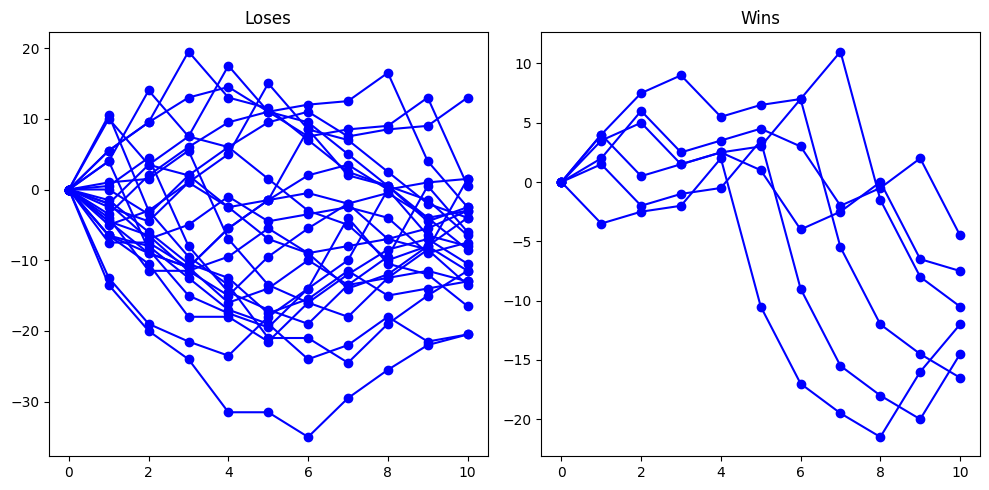

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for index in range(30):
    if y[index] == 0:
        axs[0].plot(X[index], marker='o', linestyle='-', color='b')
axs[0].set_title('Loses')

for index in range(30):
    if y[index] == 1:
        axs[1].plot(X[index], marker='o', linestyle='-', color='b')
axs[1].set_title('Wins')

plt.tight_layout()
plt.show()

#### Model 

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import SGD
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
import time

Connect to device 

In [31]:
device = torch.device("cpu")

Codebase

In [32]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

class LSTMClassification(nn.Module):
    def __init__(self, input_dim, hidden_dim, target_size, num_layers=1, dropout=0.2):
        super(LSTMClassification, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),  # Adding an intermediate layer
            nn.ReLU(),  # Activation function
            nn.Dropout(dropout),  # Regularization with dropout
            nn.Linear(hidden_dim // 2, target_size)
        )

    def forward(self, input_):
        lstm_out, _ = self.lstm(input_)
        # Extract the output of the last time step
        last_out = lstm_out[:, -1, :]
        logits = self.fc(last_out)
        scores = torch.sigmoid(logits)
        return scores

def save_checkpoint(state, filename='mycheckpoint.pth.tar'):
    print('=> saving checkpoint')
    torch.save(state, filename)
    
def load_checkpoint(model, checkpoint):
    print('=> loading checkpoint')
    model.load_state_dict(checkpoint['state_dic'])

def compute_precision(y_true, y_pred):
    # Convert arrays to 1D if they are not already
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

    # Calculate true positives and false positives
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    false_positives = np.sum((y_true == 0) & (y_pred == 1))

    # Calculate precision
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

    return precision

def train(model, n_epochs, data_loader, test_loader, history_dic=None, save=False, max_duration=100000):
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = SGD(model.parameters(), lr=0.001)

    if history_dic!=None:
        history = history_dic
    else:
        history = {'loss' : [], 'val_loss' : [], 'precision' : []}
    

    start_time = time.time()
    for epoch in range(n_epochs):
        print((time.time() - start_time))
        if (time.time() - start_time) > max_duration*60:
            print("Training stopped due to reaching the maximum duration.")
            break

        losses = []
        for i, data in enumerate(data_loader):
            inputs, labels = data

            inputs, labels = inputs.to(device), labels.to(device)  # Move data to CUDA

            model.zero_grad()

            tag_scores = model(inputs)

            loss = loss_function(tag_scores, labels)

            loss.backward()
            optimizer.step()
            losses.append(float(loss))
        

        # calculate loss
        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)

        # Validation
        val_labels, val_preds = evaluate_on_data_set(model, test_loader, device)
        val_loss = loss_function(torch.tensor(val_preds), torch.tensor(val_labels)).item()
        history['val_loss'].append(val_loss)
        
        
        precision = compute_precision(val_labels, val_preds)
        history['precision'].append(precision)

        print("Epoch {} / {}: Loss = {:.3f}".format(epoch + 1, n_epochs, avg_loss))

        if save == True:
            if epoch % 10 == 0:
                checkpoint = {'state_dic' : model.state_dict(), 'history': history}
                save_checkpoint(checkpoint)

    return history

def evaluate_on_data_set(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data

            # Move inputs to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            # print(outputs)
            
            # Apply sigmoid activation before thresholding
            #predicted_probs = torch.sigmoid(outputs)
            predicted = (outputs > 0.5).float()  # Convert probabilities to 0 or 1

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

Training and test set split

In [33]:
split_index = int(len(X) * 0.70)

X_train = X[:split_index].reshape((-1, 11, 1))
X_test = X[split_index:].reshape((-1, 11, 1))

y_train = y[:split_index].reshape((-1, 1))
y_test = y[split_index:].reshape((-1, 1))

In [34]:
batch_size = 1

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Create/load model

In [35]:
model = LSTMClassification(1, hidden_dim=10, target_size=1, num_layers=1, dropout=0.2)

load = True
if load == True: 
    state = torch.load('mycheckpoint.pth.tar')
    load_checkpoint(model, state)
model.to(device);

=> loading checkpoint


c:\Users\richa\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Training  

In [36]:
num_epochs = 10000000
#history = train(model, num_epochs, train_loader, train_loader, save=True, max_duration=5)
history = train(model, num_epochs, train_loader, train_loader, state['history'], save=True, max_duration=5)

0.0
Epoch 1 / 10000000: Loss = 0.696
=> saving checkpoint
3.173647165298462
Epoch 2 / 10000000: Loss = 0.689
7.411125659942627
Epoch 3 / 10000000: Loss = 0.689
11.236765623092651
Epoch 4 / 10000000: Loss = 0.690
14.207338094711304
Epoch 5 / 10000000: Loss = 0.690
17.092916250228882
Epoch 6 / 10000000: Loss = 0.690
19.973605394363403
Epoch 7 / 10000000: Loss = 0.690
22.504080533981323
Epoch 8 / 10000000: Loss = 0.690
25.072964668273926
Epoch 9 / 10000000: Loss = 0.690
27.64998507499695
Epoch 10 / 10000000: Loss = 0.690
30.24530553817749
Epoch 11 / 10000000: Loss = 0.690
=> saving checkpoint
32.87317156791687
Epoch 12 / 10000000: Loss = 0.690
35.36816167831421
Epoch 13 / 10000000: Loss = 0.690
38.001338481903076
Epoch 14 / 10000000: Loss = 0.690
40.819157123565674
Epoch 15 / 10000000: Loss = 0.690
43.179919481277466
Epoch 16 / 10000000: Loss = 0.690
45.648998737335205
Epoch 17 / 10000000: Loss = 0.690
48.303157806396484
Epoch 18 / 10000000: Loss = 0.690
50.9984016418457
Epoch 19 / 100000

History of learning logs

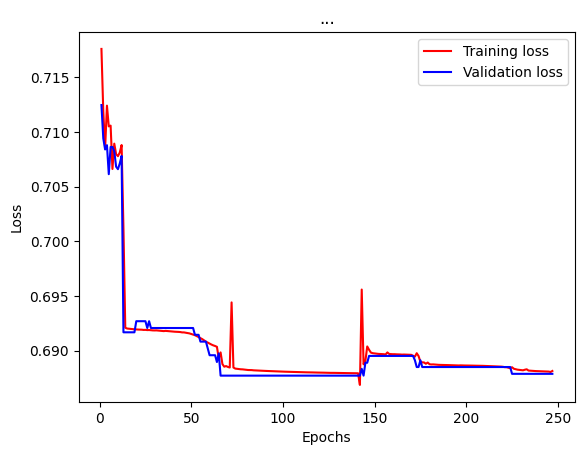

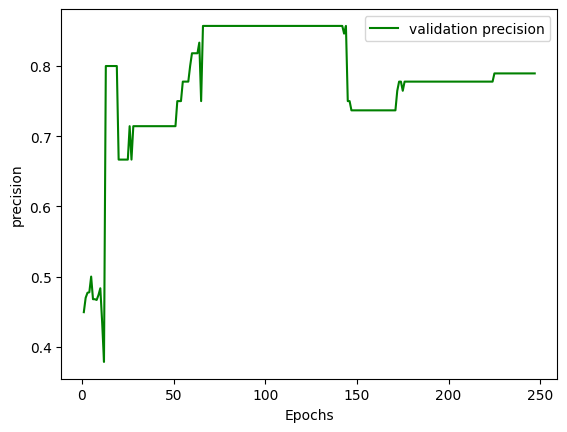

In [37]:
import matplotlib.pyplot as plt


loss_values = history['loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.title('...')
plt.xlabel('Epochs')
plt.ylabel('Loss')



loss_values = history['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


loss_values = history['precision']

epochs = range(1, len(loss_values) + 1)

plt.legend()
plt.show()

plt.plot(epochs, loss_values, 'g', label='validation precision')
plt.xlabel('Epochs')
plt.ylabel('precision')


plt.legend()
plt.show()


In [38]:
from sklearn.metrics import confusion_matrix

true_labels_train, predicted_labels_train = evaluate_on_data_set(model, train_loader, device)
conf_matrix_train = confusion_matrix(true_labels_train, predicted_labels_train)

print("Confusion Matrix (on training set):")
print(conf_matrix_train)
losses = conf_matrix_train[0,1]
wins = conf_matrix_train[1,1]
print("Training set-")
print('wins:', wins, 'losses:',losses)
accuracy = round(wins/(losses+wins), 2)
print('Accuracy:', accuracy)

true_labels_train, predicted_labels_train = evaluate_on_data_set(model, test_loader, device)
conf_matrix_train = confusion_matrix(true_labels_train, predicted_labels_train)

print("Confusion Matrix (on test set):")
print(conf_matrix_train)
losses = conf_matrix_train[0,1]
wins = conf_matrix_train[1,1]
accuracy = round(wins/(losses+wins), 2)
print("Test set-")
print('wins:', wins, 'losses:',losses)
print('Accuracy:', accuracy)

Confusion Matrix (on training set):
[[341   4]
 [250  15]]
Training set-
wins: 15 losses: 4
Accuracy: 0.79
Confusion Matrix (on test set):
[[151  10]
 [ 99   2]]
Test set-
wins: 2 losses: 10
Accuracy: 0.17


Modifly the threshold for postive class to 0.99.

In [149]:
def evaluate_on_data_set(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            predicted = (outputs > 0.99).float()  # Convert probabilities to 0 or 1

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

true_labels_train, predicted_labels_train = evaluate_on_data_set(model, train_loader, device)
conf_matrix_train = confusion_matrix(true_labels_train, predicted_labels_train)

print("Training set-")
print(conf_matrix_train)
losses = conf_matrix_train[0,1]
wins = conf_matrix_train[1,1]
print('wins:', wins, 'losses:',losses)
accuracy = round(wins/(losses+wins), 2)
print('Trading Accuracy:', accuracy)

true_labels_train, predicted_labels_train = evaluate_on_data_set(model, test_loader, device)
conf_matrix_train = confusion_matrix(true_labels_train, predicted_labels_train)

print("Test set-")
print(conf_matrix_train)
losses = conf_matrix_train[0,1]
wins = conf_matrix_train[1,1]
accuracy = round(wins/(losses+wins), 2)
print('wins:', wins, 'losses:',losses)
print('Trading Accuracy:', accuracy)

Training set-
[[343   2]
 [262   3]]
wins: 3 losses: 2
Trading Accuracy: 0.6
Test set-
[[154   7]
 [ 99   2]]
wins: 2 losses: 7
Trading Accuracy: 0.22


#### Hyperparmater tuning  

A simple grid search will be applied to optimize the hyperparamters of the model.

In [151]:
def objective_function(data, parameters):
    X_train, y_train, X_test, y_test = data
    num_epochs = parameters['num_epochs']
    batch_size =  parameters['batch_size']
    hidden_dim =  parameters['hidden_dim']

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model = LSTMClassification(1, hidden_dim=hidden_dim, target_size=1)
    num_epochs = num_epochs
    model.to(device)
    history = train(model, num_epochs, train_loader, test_loader, max_duration=1)
    return history

def batch_search(objective_function, grid):
    
    result = {'parameters_combination' : [], 'history' : []} 

    for parameters_combination in grid:
        print('combination', parameters_combination)
        num_epochs, batch_size, hidden_dim = parameters_combination
        num_epochs = int(num_epochs)
        batch_size = int(batch_size)
        hidden_dim = int(hidden_dim)
        parameters = {'num_epochs' : num_epochs, 'batch_size' : batch_size, 'hidden_dim' : hidden_dim }
        history = objective_function(data, parameters)
        
        result['parameters_combination'].append(parameters_combination)
        result['history'].append(history)

    return result 

def evaluate_on_data_set(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            predicted = (outputs > 0.9999).float()  # Convert probabilities to 0 or 1

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

In [153]:
data = X_train, y_train, X_test, y_test
parameter_ranges = {
    'num_epochs': [10],
    'batch_size': [1, 5],
    'hidden_dim': [1, 2]
}
param_values = [np.array(parameter_ranges[param_name]) for param_name in parameter_ranges.keys()]
grid = np.meshgrid(*param_values)
grid = np.vstack([dim.reshape(-1) for dim in grid]).T

result = batch_search(objective_function, grid)

combination [10  1  1]
0.0


C:\Users\richa\AppData\Local\Temp\ipykernel_26556\1935764922.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
C:\Users\richa\AppData\Local\Temp\ipykernel_26556\1935764922.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
C:\Users\richa\AppData\Local\Temp\ipykernel_26556\1935764922.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
C:\Users\richa\

Epoch 1 / 10: Loss = 0.756
2.6198177337646484
Epoch 2 / 10: Loss = 0.755
6.161748886108398
Epoch 3 / 10: Loss = 0.754
10.715968608856201
Epoch 4 / 10: Loss = 0.752
16.242716312408447
Epoch 5 / 10: Loss = 0.751
19.947370290756226
Epoch 6 / 10: Loss = 0.750
24.011680603027344
Epoch 7 / 10: Loss = 0.749
29.489911556243896
Epoch 8 / 10: Loss = 0.747
35.68423509597778
Epoch 9 / 10: Loss = 0.746
41.73913550376892
Epoch 10 / 10: Loss = 0.745
combination [10  1  2]
0.0
Epoch 1 / 10: Loss = 0.745
4.086088180541992
Epoch 2 / 10: Loss = 0.745
7.81634783744812
Epoch 3 / 10: Loss = 0.744
11.310136079788208
Epoch 4 / 10: Loss = 0.742
15.76106071472168
Epoch 5 / 10: Loss = 0.741
19.246877193450928
Epoch 6 / 10: Loss = 0.740
25.144559144973755
Epoch 7 / 10: Loss = 0.738
31.95740270614624
Epoch 8 / 10: Loss = 0.737
36.146151065826416
Epoch 9 / 10: Loss = 0.736
39.650535583496094
Epoch 10 / 10: Loss = 0.735
combination [10  5  1]
0.0
Epoch 1 / 10: Loss = 0.757
2.0860953330993652
Epoch 2 / 10: Loss = 0.7

In [19]:
# import matplotlib.pyplot as plt

# for index, instances in enumerate(result['history']):
#     plt.figure()
#     plt.plot(instances['loss'], label='Training Loss')
#     plt.plot(instances['val_loss'], label='Validation Loss')
#     plt.title('Parameter Combination: ' + str(result['parameters_combination'][index]))
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()

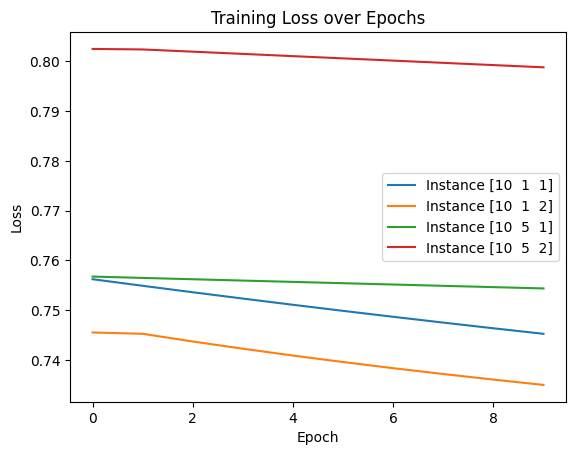

In [154]:
for index, instance in enumerate(result['history']):
    plt.plot(instance['loss'], label=f'Instance {result["parameters_combination"][index]}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


#### Results

A model instance was created and then trained for 1000000 epochs on 0.7 of the data. The loss obtained was 0.68. The following results were obtained 

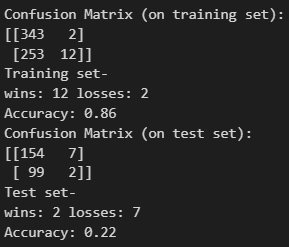

The training loss and validation loss for the last 140 epoch of the training are shown.

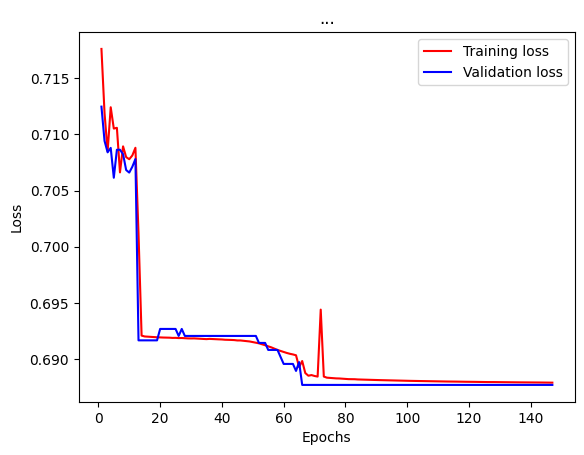

The threshold for postive classes was modified to 0.99 to try increase the preceison. The following results were - 

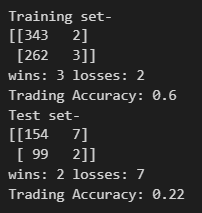

Hyperparemteizing tuning provided some further diagnosie of the model performances

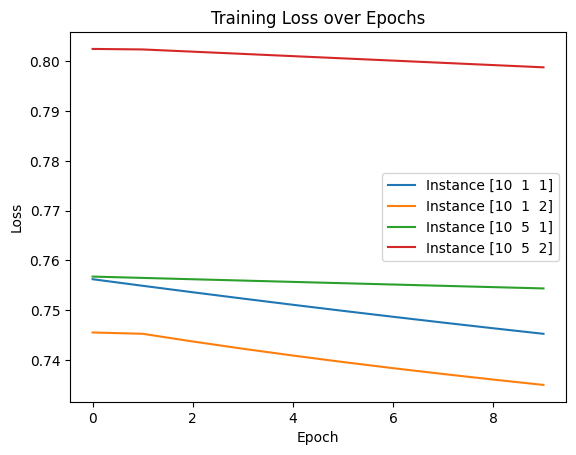

#### Summary 

The results highlight the need for more extensive training and hyperparameter tuning for better performing models. The loss was difficult to reduce finishing with a value of 0.68. Furthermore though the precision was good for the training data, the precision drastically dropped when applied to the validation data. It can be seen in the confusion matrix the large majority of class predictions are 0. For a more robust model the number of predicted 1 needs to be a larger proportion. The resulting trading accuracy of 0.2 from the validation data is not a profitable trading given the risk to reward is 1:1. Though the current model is not profitable the project has outlines some core elements when using machine learning for trading models.  

The following work needs further developments such as a section for exploratory data analysis, to refine a the trading strategy or the introduction of other features. The model also needs to be revisited with an extensive search of the hyperparameter space an potential increase in overall performance. Furthermore the architecture of the neural network could also be revised. The strategy could also be experimented with to see the changes in trading performance. For example strategies with multiple open positions allowed for more sophisticated trades which could lead to more certain patterns in the data for leaning and realizing higher performing models.   Reinforcement learning is another branch of machine learning that could be used to learning profitable trading actions due to the sequential nature of trading decisions. 